#### Setup

In [1]:
# Get data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-24 15:01:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.04s   

2023-09-24 15:01:23 (32.5 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### EDA

In [3]:
# Load the data
df = pd.read_csv('housing.csv')
print(f"Rows: [{df.shape[0]}]")
print(f"Cols: [{df.shape[1]}]")
df.head(5)

Rows: [20640]
Cols: [10]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Target
df["median_house_value"].describe().to_frame().round(2)

,median_house_value
count,20640.00
mean,206855.82
std,115395.62
min,14999.00
25%,119600.00
50%,179700.00
75%,264725.00
max,500001.00


/home/jjovalle99/micromamba/envs/mlzoomcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jjovalle99/micromamba/envs/mlzoomcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of prices')

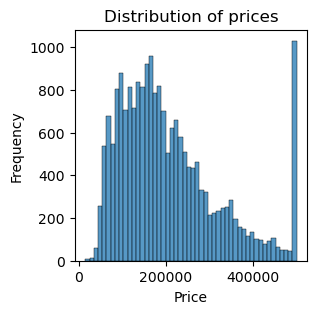

In [5]:
# Target distribution
plt.figure(figsize=(3, 3))
sns.histplot(df["median_house_value"], bins=50)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

#### Preparing the dataset

In [6]:
df_filtered = df.copy()[df["ocean_proximity"].isin(['<1H OCEAN', 'INLAND'])]

In [7]:
# Question 1 - There's one feature with missing values. What is it?
df_filtered.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
# Question 2 - What's the median (50% percentile) for variable 'population'?
df_filtered.population.median()

1195.0

#### Prepare and Split dataset

In [9]:
def split_dataset(
    seed: int,
    data: pd.DataFrame,
    target: str,
    val_ratio: float,
    test_ratio: float,
    transform_target: bool = True
) -> tuple:
    
    # Copy of data
    data = data.copy()
    
    # Set seed
    np.random.seed(seed)
    
    # Get len of data splits
    n = len(data)
    n_val, n_test,  = int(val_ratio * n), int(test_ratio * n)
    n_train = n - (n_val + n_test)
    
    # Shuffle data
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = data.iloc[idx]
    
    # Get data splits
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    # Get X and y
    X_train, y_train = df_train.drop(target, axis=1), df_train[target]
    X_val, y_val = df_val.drop(target, axis=1), df_val[target]
    X_test, y_test = df_test.drop(target, axis=1), df_test[target]
    
    # Transform target
    if transform_target:
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        y_test = np.log1p(y_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(
    seed=42,
    data=df_filtered,
    target="median_house_value",
    val_ratio=0.2,
    test_ratio=0.2,
    transform_target=True
)

#### Modeling

In [11]:

def prepare_X(df, base, value):
    df = df.copy()
    df_num = df[base]
    df_num = df_num.fillna(value)
    X = df_num.values
    return X

def train_linear_regression_reg(X, y, r=None):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    if r:
        reg = r * np.eye(XTX.shape[0])
        XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse), 2)

def evaluate_model_rmse(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    base: list,
    fill_strategy,
    r: int = None
) -> float:
    if fill_strategy == "mean":
        fill_strategy = X_train["total_bedrooms"].mean()

    print(f"Fill strategy: {fill_strategy}")
    X_train, X_val = prepare_X(X_train, base, fill_strategy), prepare_X(X_val, base, fill_strategy)
    intercept, coef = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = intercept + X_val.dot(coef)
    return rmse(y_val, y_pred)

In [12]:
# Question 3 
base = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
value = [0, "mean"]

for val in value:
    print(f"Results for value: {val}")
    print(
        evaluate_model_rmse(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            base=base,
            fill_strategy=val,
            r=None
        )
    )
    print("-" * 20)

Results for value: 0
Fill strategy: 0
0.34
--------------------
Results for value: mean
Fill strategy: 542.552956325786
0.34
--------------------


In [13]:
#### Question 4
fill_strategy = 0
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
for r_val in r_values:
    print(f"Results for regularization: {r_val}")
    print(
        evaluate_model_rmse(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            base=base,
            fill_strategy=fill_strategy,
            r=r_val
        )
    )
    print("-" * 20)

Results for regularization: 0
Fill strategy: 0
0.34
--------------------
Results for regularization: 1e-06
Fill strategy: 0
0.34
--------------------
Results for regularization: 0.0001
Fill strategy: 0
0.34
--------------------
Results for regularization: 0.001
Fill strategy: 0
0.34
--------------------
Results for regularization: 0.01
Fill strategy: 0
0.34
--------------------
Results for regularization: 0.1
Fill strategy: 0
0.34
--------------------
Results for regularization: 1
Fill strategy: 0
0.34
--------------------
Results for regularization: 5
Fill strategy: 0
0.35
--------------------
Results for regularization: 10
Fill strategy: 0
0.35
--------------------


In [14]:
%%capture
#### Question 5
fill_strategy = 0
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmses = []
for seed in seeds:
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(
        seed=seed,
        data=df_filtered,
        target="median_house_value",
        val_ratio=0.2,
        test_ratio=0.2,
        transform_target=True
    )
  
    rmses.append(
        evaluate_model_rmse(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            base=base,
            fill_strategy=fill_strategy,
            r=r_val
        )
    )

In [15]:
round(np.std(rmses), 3)

0.006

In [16]:
#### Question 6
seed = 9
fill_strategy = 0
r = 0.001

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(
    seed=seed,
    data=df_filtered,
    target="median_house_value",
    val_ratio=0.2,
    test_ratio=0.2,
    transform_target=True
)

new_x_train = pd.concat([X_train, X_val], axis=0)
new_y_train = pd.concat([y_train, y_val], axis=0)

print(
    evaluate_model_rmse(
        X_train=new_x_train,
        y_train=new_y_train,
        X_val=X_test,
        y_val=y_test,
        base=base,
        fill_strategy=fill_strategy,
        r=r
    )
)

Fill strategy: 0
0.33
